In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [3]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [4]:
#Delete useless company
target_date = pd.Timestamp('2021-08-02')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [6]:
#Data for simulate
start_date = pd.Timestamp('2021-08-02')
end_date = pd.Timestamp('2022-11-16')


pred_date = pd.Timestamp('2023-05-16')

#Get data for a specific time period
true_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

pred_stock_data = stock_data[(stock_data['Date'] == pred_date)][['Company', 'Close']].rename(columns={'Close': 'true_y'})


In [7]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = true_stock_data[(true_stock_data['Company'] == company) & (true_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        open_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(open_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(open_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': None})

#Calculate the signature
signatures = true_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
true_stock_data = true_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [8]:
#Change 1 col into 6
true_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(true_stock_data['Signature'].tolist(), index=true_stock_data.index)

#Delete old col
true_stock_data = true_stock_data.drop(columns=['Signature'])


In [9]:
true_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
316896,2021-08-02,144.279564,144.861174,143.185341,143.451508,62880000,0.0,0.0,AAPL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
316897,2021-08-02,280.158330,280.559454,277.595076,278.651703,16267400,0.0,0.0,MSFT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
316898,2021-08-02,135.117004,135.336502,133.794006,134.854507,21634000,0.0,0.0,GOOGL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
316899,2021-08-02,167.654999,167.945999,165.850006,166.574005,67078000,0.0,0.0,AMZN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
316900,2021-08-02,196.687180,199.293036,193.302564,197.186386,21744400,0.0,0.0,NVDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476126,2022-11-16,26.520608,27.109312,26.482006,26.925945,4910900,0.0,0.0,PPL,0.853825,0.457647,0.853825,0.364508,0.457647,0.104720
476127,2022-11-16,34.699649,34.813885,33.899986,34.071342,3825700,0.0,0.0,FITB,1.042011,1.166822,1.042011,0.542894,1.166822,0.680737
476128,2022-11-16,93.965866,95.013459,93.418044,94.590576,1828700,0.0,0.0,IFF,-44.533157,-46.924940,-44.533157,991.601052,-46.924940,1100.975019
476129,2022-11-16,24.445329,24.644556,23.827720,23.897449,3196300,0.0,0.0,CCJ,6.580116,6.432522,6.580116,21.648965,6.432522,20.688666


In [10]:
#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = true_stock_data[true_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2021-08-02').date()) & (company_data['Date'] <= pd.Timestamp('2022-05-16').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-11-16').date())]['Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-11-16').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

    
#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
true_result = pred_stock_data.merge(results_df, on='Company')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e+00, tolerance: 2.825e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17583213460318348, tolerance: 0.09245459282156843
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21736259356384835, tolerance: 0.09245459282156843
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e+00, tolerance: 1.598e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.78260363906156, tolerance: 25.529165244814514
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.040179337825975, tolerance: 25.529165244814514
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7922873108727799, tolerance: 0.7915870025175847
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1408765610867704, tolerance: 1.8012329354531966
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.121112509707018, tolerance: 1.8012329354531966
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1929362009580018, tolerance: 0.11000587208268174
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2164261195580366, tolerance: 0.11000587208268174
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22158768146925922, tolerance: 0.11000587208268174
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.633615175567229, tolerance: 0.2971790571831017
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8344807819501057, tolerance: 0.2971790571831017
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8307296469874927, tolerance: 0.2971790571831017
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.793553420924582, tolerance: 6.897743427192145
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.723543926535058, tolerance: 6.897743427192145
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.11710503933864, tolerance: 6.897743427192145
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17966917628075407, tolerance: 0.06637231247126557
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23673931459455844, tolerance: 0.06637231247126557
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26205136066715795, tolerance: 0.06637231247126557
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.859370812650013, tolerance: 9.516360061890072
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-01, tolerance: 4.061e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e+00, tolerance: 4.387e-01
  model = cd_fast.enet_coordinate_de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.41786054776458, tolerance: 19.7135725528849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.8242835510391, tolerance: 19.7135725528849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+00, tolerance: 1.470e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sk

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024432908725643188, tolerance: 0.006816346723724732
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032787246734223174, tolerance: 0.006816346723724732
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035817379712092645, tolerance: 0.006816346723724732
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9652023686739994, tolerance: 0.9107757176527915
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0276203395487755, tolerance: 0.9107757176527915
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0537493356596315, tolerance: 0.9107757176527915
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6660121719673953, tolerance: 0.5033882290474203
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8752734342529038, tolerance: 0.5033882290474203
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8977803413408765, tolerance: 0.5033882290474203
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7190022446038711, tolerance: 0.648628101601306
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7269678701813973, tolerance: 0.648628101601306
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8131596382227144, tolerance: 0.648628101601306
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.012e-01, tolerance: 3.603e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0563434458894676, tolerance: 0.03213462821549153
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+00, tolerance: 2.449e+00
  model = cd_fast.enet_coordinate_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.936656859528739, tolerance: 1.7413185974493532
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3467293101166433, tolerance: 1.7413185974493532
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.470691274604178, tolerance: 1.7413185974493532
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0447790507912487, tolerance: 0.10995890137890693
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2401859058073796, tolerance: 0.10995890137890693
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2708931640543142, tolerance: 0.10995890137890693
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

In [11]:
#Calcilate difference
true_result["difference"] = (true_result["true_y"] - true_result["predicted_y"]).abs()
true_result["difference_percentage"] = (true_result["difference"] / true_result["true_y"]) * 100

#Sort by difference
true_result_sorted = true_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(true_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(true_result_sorted.tail(10))

10 lines with lowest difference:
    Company      true_y  predicted_y  difference  difference_percentage
443     HPE   13.840818    13.802703    0.038116               0.275385
335    NDAQ   54.071663    53.974954    0.096708               0.178852
65      TXN  160.766403   160.667238    0.099166               0.061683
143      MO   43.196602    43.311542    0.114940               0.266086
144     CNI  118.661865   118.508643    0.153222               0.129125
83      SNY   52.573071    52.400165    0.172905               0.328886
392     CAH   84.849846    84.667651    0.182195               0.214726
254    ABEV    2.940000     2.713965    0.226035               7.688282
411    RBLX   39.250000    39.005058    0.244942               0.624055
317     LYG    2.191127     1.912060    0.279067              12.736244

 10 lines with highest difference:
    Company       true_y  predicted_y   difference  difference_percentage
394     WST   354.168060   149.812475   204.355586              5

In [12]:
#Calculate overall R² score
overall_r2_score = r2_score(true_result['true_y'], true_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.9228542760507941


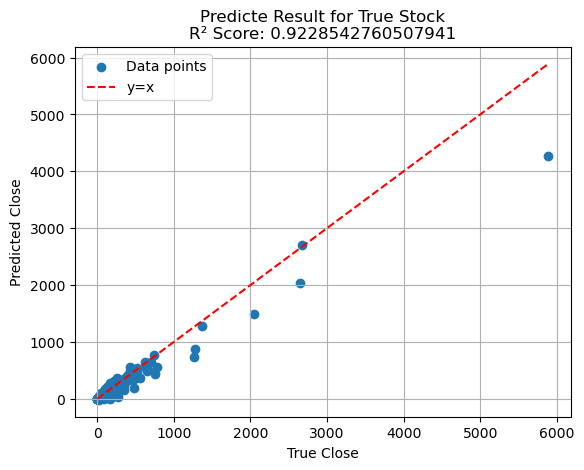

In [13]:
#Plot
plt.scatter(true_result['true_y'], true_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for True Stock\nR² Score: {overall_r2_score}')
plt.plot([true_result['true_y'].min(), true_result['true_y'].max()], [true_result['true_y'].min(), true_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()

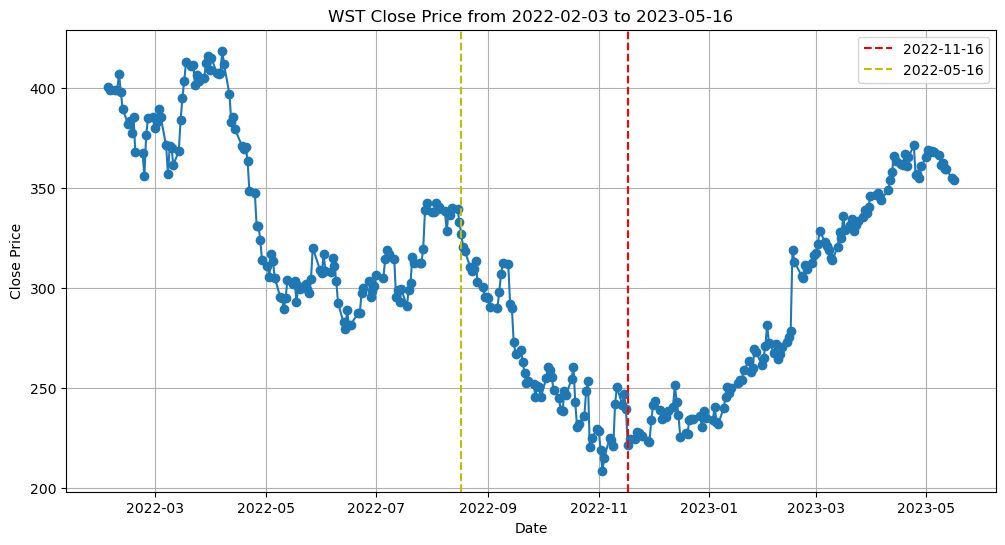

In [14]:
companyplot = 'WST'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()

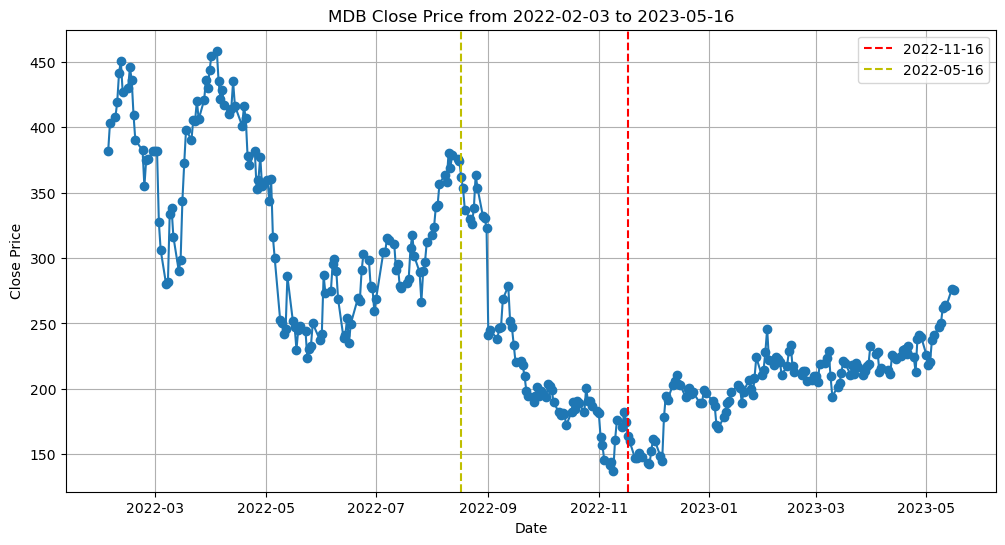

In [15]:
companyplot = 'MDB'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()

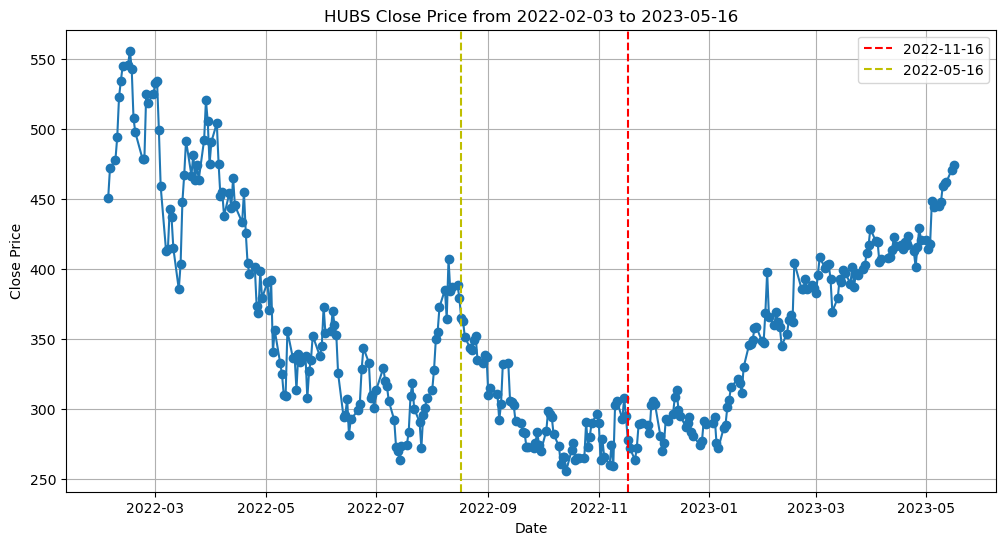

In [16]:
companyplot = 'HUBS'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()

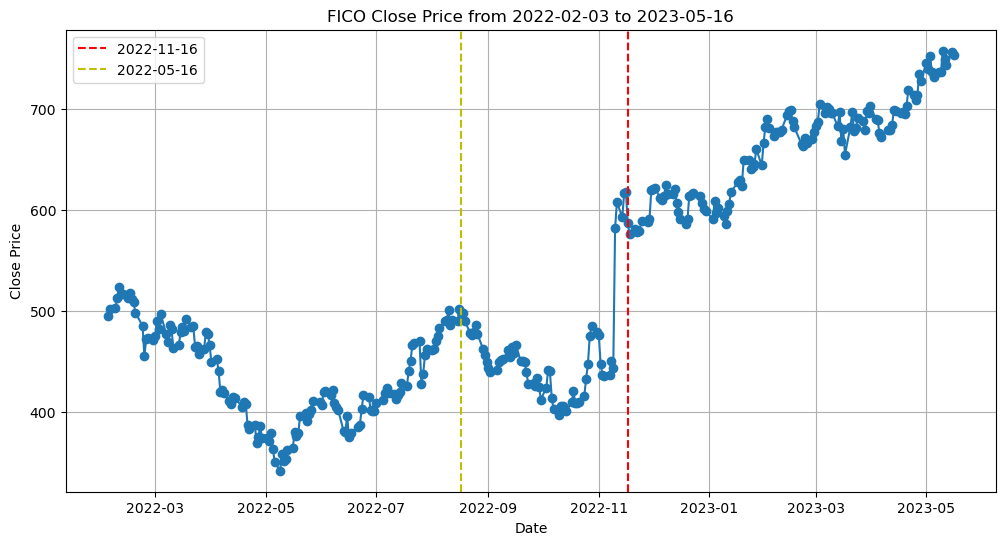

In [17]:
companyplot = 'FICO'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()

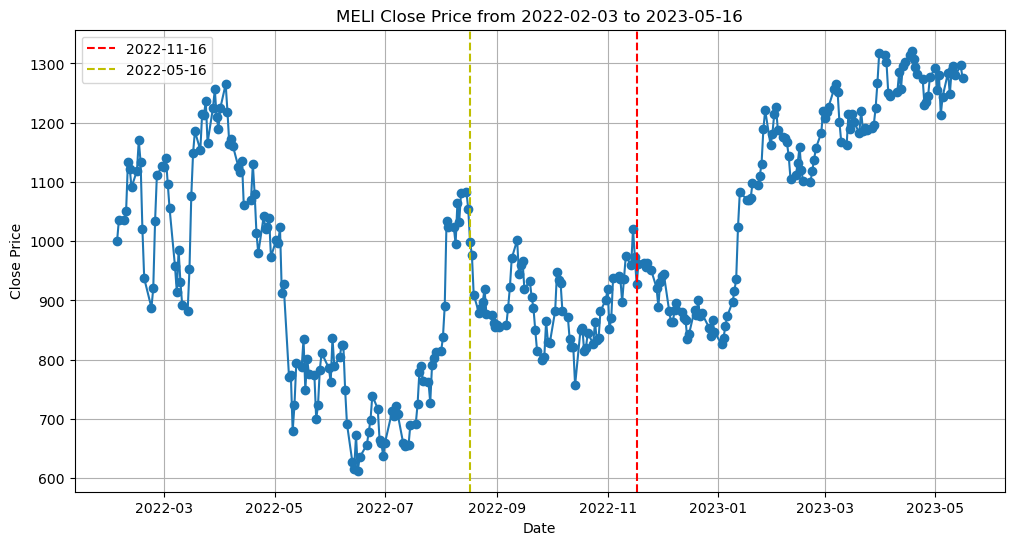

In [18]:
companyplot = 'MELI'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()

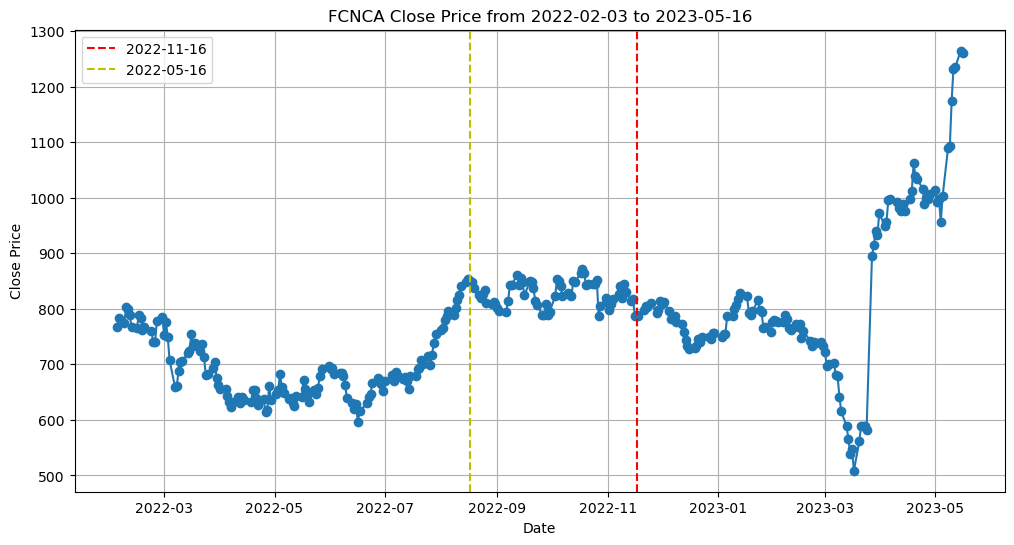

In [19]:
companyplot = 'FCNCA'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-02-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-05-16').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-02-03 to 2023-05-16')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-16')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-05-16')
plt.legend()

plt.show()